In [1]:
using Revise
using Pkg; Pkg.activate("..")

using Dates
using Interpolations
using CSV
using MAT
using NCDatasets
using DataFrames
using PyPlot

using Psychrometrics
include("./VaporSat.jl")
using .VaporSat

  Activating project at `~/Projects/submersible_humidity_sensor`


In [2]:
# data helper functions
md2dt(md) = DateTime(-1,12,31) + Day(floor(md)) + Millisecond(round(86_400_000*(md%1)))

m2n(x) = replace(x, missing=>NaN)

m2n (generic function with 1 method)

In [3]:
# test reading WXT MAT file
wxt = matread("../data/20251211Tank/20251208_SHS-test_EGH_WXT/processed/ASWXT203.mat")

Dict{String, Any} with 38 entries:
  "hail_accumulation"   => [0.0; 0.0; … ; 0.0; 0.0;;]
  "rain_duration"       => [0.0; 0.0; … ; 50.0; 50.0;;]
  "wnde_avg"            => [-0.0241835; 0.0570489; … ; 0.0642299; 0.0858882;;]
  "wdir_avg"            => [313.039; 103.736; … ; 63.6313; 68.5511;;]
  "hrh"                 => [16.8; 16.9; … ; 38.0; 37.9;;]
  "compass11"           => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 152.9 152…
  "bpr"                 => [1020.3; 1020.3; … ; 994.8; 994.8;;]
  "wspd_avg"            => [0.0410351; 0.0731177; … ; 0.0679381; 0.0933986;;]
  "mday"                => [7.3996e5; 7.3996e5; … ; 739962.0; 739962.0;;]
  "wspd11"              => [0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.0 0.1; … ; 0.1 0.1 ……
  "precip"              => [0.0; 0.0; … ; 0.1; 0.1;;]
  "rhtpflag"            => [0.0; 0.0; … ; 0.0; 0.0;;]
  "hail_duration"       => [0.0; 0.0; … ; 0.0; 0.0;;]
  "compass_avg"         => [0.0; 151.242; … ; 152.864; 152.839;;]
  "tilt_x"              => [-1.02727; -1.0

In [4]:
# tank_temp = vcat(CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251208_SHS-test_EGH.txt", DataFrame),
#                  CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251209_SHS-test_EGH.txt", DataFrame))
tmp = CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251209_SHS-test_EGH.txt", DataFrame) # includes 20251209
tank_temp = tmp[!,2] # second column is temperature
str2dt(s) = startswith("[", s) ?  DateTime(strip(s, ['[', ']']), dateformat"e u dd HH:MM:SS.sss yyyy") : missing
tank_time = str2dt.(tmp[!,1]) # first column is timestamp
clf()s
plot(m2n(tank_time), tank_temp, label="Tank T") # bad time axis
gcf()

UndefVarError: UndefVarError: `s` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

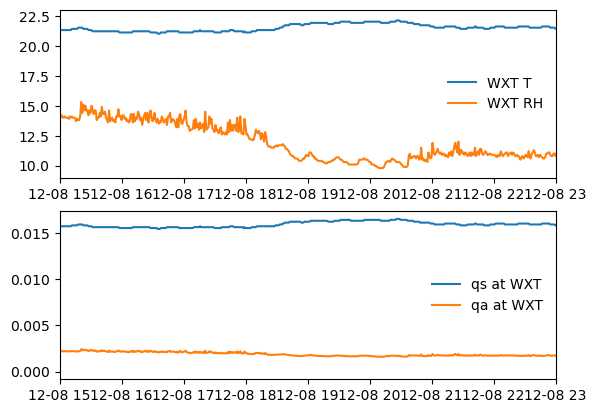

In [5]:
#plot WXT data
clf()
subplot(2,1,1)
plot(md2dt.(wxt["mday"]), wxt["atmp"], label="WXT T")
plot(md2dt.(wxt["mday"]), wxt["hrh"], label="WXT RH")
legend(frameon=false)
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([9.0,23.0])
subplot(2,1,2)
plot(md2dt.(wxt["mday"]), qs.(101325.0,wxt["atmp"]), label="qs at WXT")
plot(md2dt.(wxt["mday"]), qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="qa at WXT")
legend(frameon=false)
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
gcf()


In [6]:
# test reading RBR thermistors
rbr = NCDataset("../data/20251211Tank/20251208_SHS-test_EGH_RBR/233860_20251211_1631.nc")
events_rbr = CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_RBR/233860_20251211_1631_events.txt", DataFrame)
rbrT  = rbr["temperature"][:]
rbrTw = rbr["temperature1"][:] # wet bulb

529089-element Vector{Float64}:
 21.17946163460101
 21.17946163460101
 21.17946163460101
 21.178361407249156
 21.178361407249156
 21.178361407249156
 21.178361407249156
 21.177970831634525
 21.177970831634525
 21.177970831634525
  ⋮
 21.17416423445775
 21.17416423445775
 21.17416423445775
 21.17416423445775
 21.19134544044755
 21.19134544044755
 21.19134544044755
 21.19134544044755
 21.198944669982154

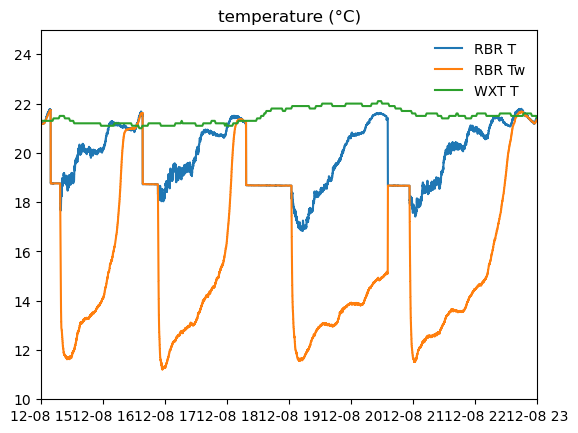

In [7]:
# plot some temperatures of the tank test
clf()
plot(rbr["time"][:], rbr["temperature"][:], label="RBR T")
plot(rbr["time"][:], rbr["temperature1"][:], label="RBR Tw") # wet bulb
plot(md2dt.(wxt["mday"]), wxt["atmp"], label="WXT T")
#plot(md2dt.(wxt["mday"]), wxt["hrh"], label="WXT RH")
legend(frameon=false)
title("temperature (°C)")
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([10,25])
gcf()

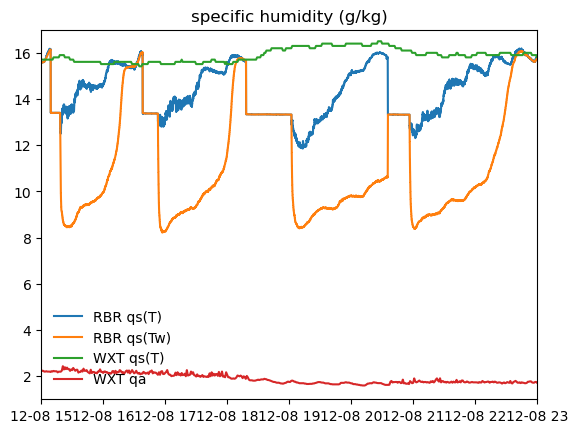

In [8]:
# plot some specific humidities of the tank test
clf()
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature"][:]), label="RBR qs(T)")
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature1"][:]), label="RBR qs(Tw)") # wet bulb
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]), label="WXT qs(T)")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="WXT qa")
legend(frameon=false)
title("specific humidity (g/kg)")
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([1,17])
gcf()

In [9]:
Cp = VaporSat.Cp  # J/(kg·K)
LvC = VaporSat.LvC  # J/kg, function of T °C
qs = VaporSat.qs  # qs(p[Pa],T[C])

qs (generic function with 1 method)

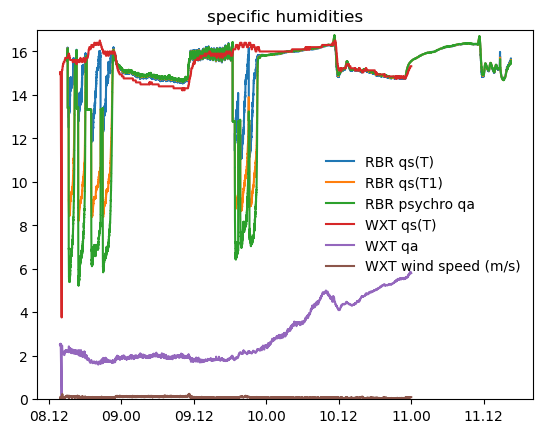

In [ ]:
# compute qa from T and Tw
#qsTw = VaporSat.qs(1013.25, rbr["temperature1"][:])
# qa - qs(p,Tw) = Cp/LvC(T) * (T-Tw)
q_air_fcn(T,Tw,p=101325.0) = qs(p,Tw) - Cp/LvC(T) * (T-Tw)
qa = q_air_fcn.(rbr["temperature"][:], rbr["temperature1"][:])

mdates = PyPlot.matplotlib.dates

clf()
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature"][:]), label="RBR qs(T)")
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature1"][:]), label="RBR qs(T1)")
plot(rbr["time"][:], 1e3*qa, label="RBR psychro qa")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]), label="WXT qs(T)")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="WXT qa")
plot(md2dt.(wxt["mday"]), wxt["wspd"], label="WXT wind speed (m/s)")
legend(frameon=false)
title("specific humidities")
# xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
# xlim([DateTime(2025,12,9,18), DateTime(2025,12,10,0)]) # 2 nice tests
ylim([0,17])
ax = gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%H"))
gcf()

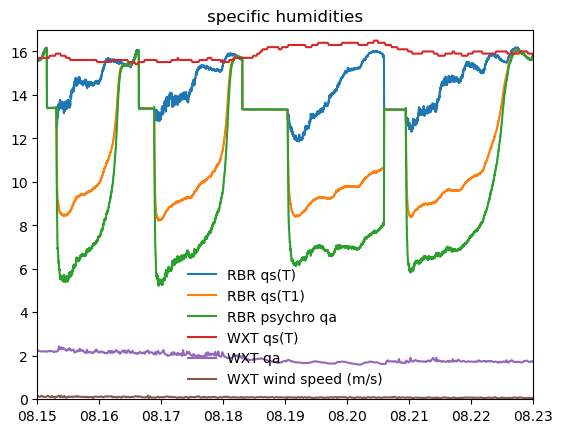

In [ ]:
# 4 nice tests
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)])
gcf()

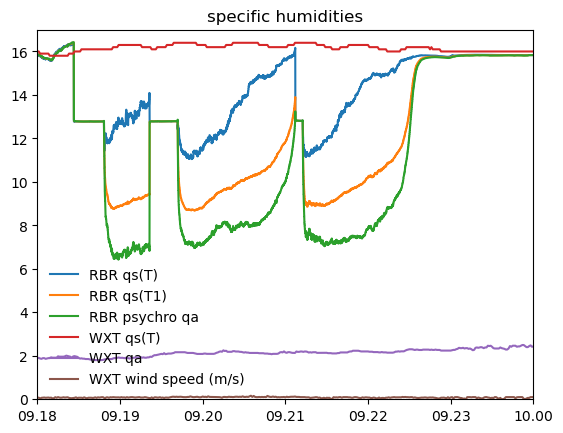

In [ ]:
# 2 nice tests
xlim([DateTime(2025,12,9,18), DateTime(2025,12,10,0)])
gcf()

In [11]:
qa_est = q_air_fcn.(21.3, 9.5) # 0.0024840466727118014
# T1 not measured below 11 C when WXT qa = 0.025.

0.0024840466727118014

In [12]:
spechum(W) = W/(1+W) # W is mixing ratio
qs(101325.0,12.0) # 0.00865781959506277
psychro( Tdry=12.0+273.15, φ=1.0 ).Wsat
a = psychro( Tdry=22.0+273.15, φ=0.14 )
a.Twet-273.15 # 9.500 C
q_air_fcn.(22.0, 9.5), spechum(a.W) # agree within 5%

# Air humidity is very low. 
# Wet bulb temperature 9.5 C is lower than temperature1

(0.002193490412388921, 0.0022758778368098783)

In [13]:
# clf()
# a = psychro( Tdry=20.0+273.15, Twet=12.0+273.15, fig=false)
a = psychro( Tdry=22.0+273.15, φ=0.014, fig=false)
# (
#     Tdry, # dry bulb temperature
#     Twet, # wet bulb temperature
#     Tdew, # dew point temperature
#     Tadiab, # adiabatic saturation temperature
#     W, # humidity
#     Wsat, # saturation humidity
#     Wsatwet, # saturation humidity at wet bulb temperature
#     Wadiab, # adiabatic saturation humidity
#     φ, # relative humidity
#     h, # specific enthalpy
#     v, # specific volume
#     pw, # water vapor pressure
#     psat, # saturation pressure
#     psatwet, # saturation pressure at wet bulb temperature
#     ρ # density
#     )
a.Wsat
# gca()

0.016668898521790675